In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

# Encoder network (same as before)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 8 * 8, 128)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc(x)
        return x

# Updated contrastive loss function
def nt_xent_loss(output, temperature=0.5):
    labels = torch.cat([torch.arange(output.shape[0]/2) for i in range(2)], dim=0)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
    labels = labels.to(output.device)

    similarity_matrix = torch.matmul(output, output.T)
    
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(labels.shape[0], dtype=torch.bool).to(output.device)
    labels = labels[~mask].view(labels.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(output.device)

    logits = logits / temperature
    return nn.CrossEntropyLoss()(logits, labels)

# Data augmentation for tensor inputs
tensor_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
])

# Data loading
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=2)

# Initialize the model, optimizer, and device (same as before)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Encoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        # Get two batches of the same images with different augmentations
        images1 = images.to(device)
        images2 = tensor_transform(images).to(device)

        # Forward pass
        output1 = model(images1)
        output2 = model(images2)
        output = torch.cat([output1, output2], dim=0)

        # Compute loss
        loss = nt_xent_loss(output)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

print("Training finished!")

Files already downloaded and verified
Epoch [1/10], Step [100/196], Loss: 2.5278
Epoch [2/10], Step [100/196], Loss: 0.4140
Epoch [3/10], Step [100/196], Loss: 0.5046
Epoch [4/10], Step [100/196], Loss: 0.1350
Epoch [5/10], Step [100/196], Loss: 0.0874
Epoch [6/10], Step [100/196], Loss: 0.0163
Epoch [7/10], Step [100/196], Loss: 0.1086
Epoch [8/10], Step [100/196], Loss: 0.1067
Epoch [9/10], Step [100/196], Loss: 0.0377
Epoch [10/10], Step [100/196], Loss: 0.1733
Training finished!


In [10]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Files already downloaded and verified


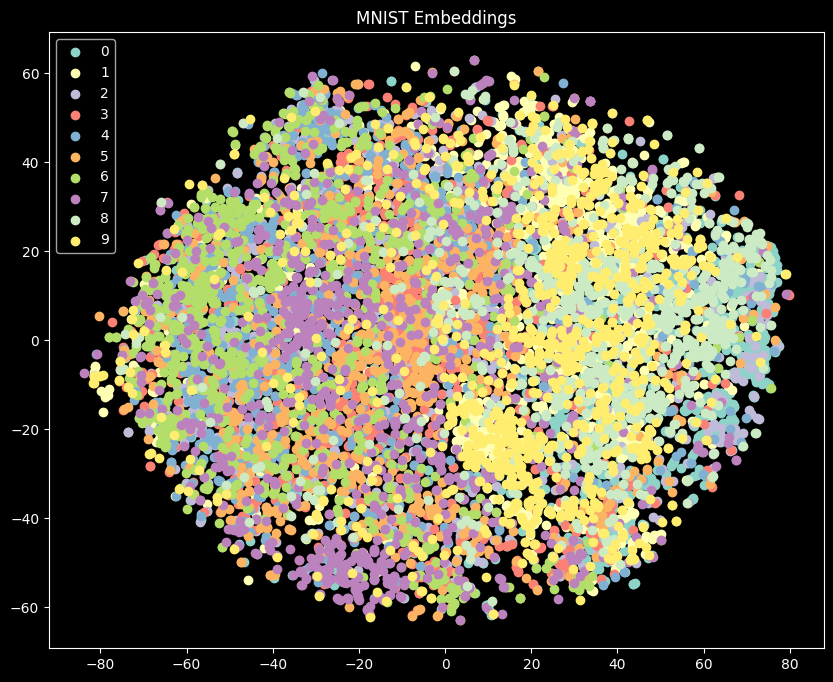

Network architecture:
Encoder(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=4096, out_features=128, bias=True)
)

Device: cpu
Batch size: 64


In [7]:
import numpy as np
import matplotlib.pyplot as plt
BATCH_SIZE = 64

# Visualize learned embeddings
def visualize_embeddings():
    model.eval()
    test_loader = DataLoader(CIFAR10(root='./data', train=False, download=True, transform=transform), batch_size=BATCH_SIZE, shuffle=True)
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            embeddings = model(images)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(labels.numpy())

    all_embeddings = np.concatenate(all_embeddings)
    # t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2).fit_transform(all_embeddings)
    
    all_labels = np.concatenate(all_labels)

    plt.figure(figsize=(10, 8))
    
    for i in range(10):
        indices = all_labels == i
        plt.scatter(tsne[indices, 0], tsne[indices, 1], label=str(i))
    
    
    plt.legend()
    plt.title('MNIST Embeddings')
    plt.show()

visualize_embeddings()

# Error checking
print("Network architecture:")
print(model)
print(f"\nDevice: {device}")
print(f"Batch size: {BATCH_SIZE}")

